# Histoplots Notebook

Last Update: 1 March 19:00

In [1]:
#Importing libraries Numpy and Matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import seaborn as sns

# Some code to make the plots look nice!
sns.set_style('ticks')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(palette = "colorblind")

import warnings
warnings.filterwarnings("ignore")

**Functions to fit (for later)**


$$
{\displaystyle f(x;\gamma,\mu_1,\sigma_1,\mu_2,\sigma_2)= \gamma {\frac {1}{\sigma_1 {\sqrt {2\pi }}}}\exp \left(-{\frac {1}{2}}{\frac {(x-\mu_1 )^{2}}{\sigma _1^{2}}}\right).} + (1-\gamma){\frac {1}{\sigma_2 {\sqrt {2\pi }}}}\exp \left(-{\frac {1}{2}}{\frac {(x-\mu_2 )^{2}}{\sigma_2 ^{2}}}\right).$$


$$
{\displaystyle f(x;\mu,\sigma)={\frac {1}{\sigma {\sqrt {2\pi }}}}\exp \left(-{\frac {1}{2}}{\frac {(x-\mu )^{2}}{\sigma ^{2}}}\right).}$$




  $$  {\displaystyle {\begin{aligned}f(x;\mu,\sigma)&={\frac {1}{x\sigma {\sqrt {2\pi \,}}}}\exp \left(-{\frac {(\ln x-\mu )^{2}}{2\sigma ^{2}}}\right).\end{aligned}}}$$



In [2]:
def double_gaussian( x, c, mu1, sigma1, mu2, sigma2 ):
    res =   c/(sigma1*np.sqrt(2*np.pi)) * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + ((1-c)/(sigma2*np.sqrt(2*np.pi))) * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def single_gaussian( x, mu1, sigma1):
    res =   1/(sigma1*np.sqrt(2*np.pi)) * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def log_gaussian( x, mu1, sigma1):
    res =   1/(x * sigma1*np.sqrt(2*np.pi)) * np.exp( - (np.log(x) - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

## 1. Masters Histograms
Import the Masters data

In [138]:
#Comparing with the data from Masters et al. (2008)

#Extracting the data from our files
Year, Month, Day, Hour, Minute = np.loadtxt("Data masters et al.txt", usecols = (1,2,3,5,6), unpack = True, dtype='str', skiprows = 1)
X_Masters, Y_Masters, Z_Masters = np.loadtxt("Data masters et al.txt", usecols = (7,8,9), unpack = True, skiprows = 1)

In [139]:
#Computing the shock stand off position for masters data
r_Masters = np.sqrt(X_Masters**2+Y_Masters**2+Z_Masters**2)
costheta_Masters = X_Masters/r_Masters
L_Masters = r_Masters*(1+1.05*costheta_Masters)
R_Masters = L_Masters/2.05
P_Masters = (12.3 / R_Masters) ** 4.3

### 1.1 R_SN Histopgram

206
14.352700094407323


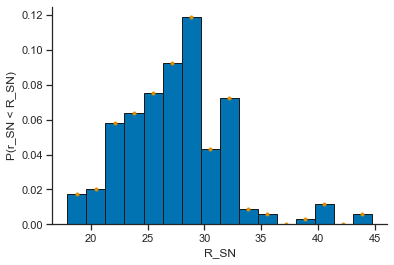

In [247]:
# histogram of solar wind dynamic pressure
data = R_Masters # select R_SN data
print(len(data))
nbins = 14 #number of bins for histogram, change bin width for optimization
print(np.sqrt(len(R_Masters)))
plt.figure()
counts, bins, bars = plt.hist(data, bins= "auto" ,density=True ,edgecolor='k')
plt.xlabel("R_SN")
plt.ylabel("P(r_SN < R_SN)")


offset = (bins[1] - bins[0])/2 # the bins start at the left corner of the plot this offset you add 
                                # puts the dot in the middle

x = bins[0:16] + offset # rename for later
y = counts

plt.plot(x, y, ".") # plot!

In [248]:
param_bounds=([0,0,0,0,0],[1,np.inf,np.inf,np.inf,np.inf]) # bounds for parameters, not less than zero
mu, sigma = stats.norm.fit(data) # for initial guesses 
log_mu, log_sigma = stats.norm.fit(np.log(data)) # for log fit initial guess
p0 =  [0.5, mu, sigma, mu, sigma ] # initial guesses 
popt, pcov = curve_fit(double_gaussian, x, y, p0=p0, bounds = param_bounds) # double fit

param_bounds=([0,0],[np.inf,np.inf]) # bounds for parameters, not less than zero
p1 = [mu, sigma]# initial guesses 
popt1, pcov1 = curve_fit(single_gaussian, x, y, p0=p1,bounds = param_bounds) # single fit
p2 = [log_mu, log_sigma]# initial guesses 
popt2, pcov2 = curve_fit(log_gaussian, x, y, p0=p2, bounds = param_bounds) # log fit

In [249]:
# print uncertanties

print("double")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("single")
print(popt1)
print(np.sqrt(np.diag(pcov1)))
print("log")
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print("exp(log)")
print(np.exp(popt2))
logerror = np.sqrt(np.exp(popt2) * (np.sqrt(np.diag(pcov2))**2))
print(logerror) # need to fix this, not 100 % sure

double
[ 0.17686578 22.12794863  1.87497876 28.15613954  3.21117607]
[0.22183423 1.52931051 1.33610562 1.0588876  0.85829508]
single
[27.24385464  4.08163216]
[0.43135518 0.35482678]
log
[3.31078655 0.15156221]
[0.01724611 0.01412995]
exp(log)
[27.40667363  1.16365069]
[0.09028576 0.01524235]


In [250]:
chi2bi = 1 - np.sum((double_gaussian(x,*popt) - y) ** 2)/np.sum((y - np.average(double_gaussian(x,*popt)))**2)
chi2norm = 1 - np.sum((single_gaussian(x,*popt1) - y) ** 2)/np.sum((y - np.average(single_gaussian(x,*popt1)))**2)
chi2log = 1 - np.sum((log_gaussian(x,*popt2) - y) ** 2)/np.sum((y - np.average(log_gaussian(x,*popt2)))**2)
print(chi2bi, chi2norm, chi2log)

0.8703051176253314 0.8521875069053718 0.8282280378942544


In [252]:
chi2bi = np.sum((double_gaussian(x,*popt) - y) ** 2)/double_gaussian(x,*popt)
chi2norm = np.sum((single_gaussian(x,*popt1) - y) ** 2)
chi2log = np.sum((log_gaussian(x,*popt2) - y) ** 2)
print(chi2bi, chi2norm, chi2log)

from scipy.special import gamma, factorial
from scipy.integrate import quad

def prob_chi2(chi2, ddof):
    num = chi2**(ddof/2-1)*np.exp(-chi2/2)
    den = 2**(ddof/2)*gamma(ddof/2)
    return num/den


#P_bi = quad(prob_chi2,chi2bi ,np.inf, args=(9))
#P_norm = quad(prob_chi2,chi2norm ,np.inf, args=(12))
#P_log = quad(prob_chi2,chi2log ,np.inf, args=(12))
#print(chi2bi, P_bi[0])
#print(chi2norm, P_norm[0])
#print(chi2log, P_log[0])

[3.12020848e-01 9.08683625e-02 5.09280371e-02 4.25273336e-02
 3.51795851e-02 2.85315649e-02 2.80493818e-02 3.58755847e-02
 6.02232409e-02 1.32759553e-01 3.84337751e-01 1.46118805e+00
 7.29533064e+00 4.78332239e+01 4.11869970e+02 4.65732353e+03] 0.0032007087816171556 0.003719108194102701


(11.311456981004227, 0.5024321575832545)

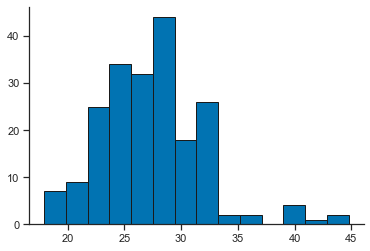

In [276]:
Obs, bins, bars = plt.hist(data, bins= nbins ,density=False ,edgecolor='k')
g = popt[0]
m1 = popt2[0]
s1 = popt2[1]
m2 = popt[3]
s2 = popt[4]
no = len(data)
E_bi = []
for i in range(len(bins)-1):
    low = bins[i]
    high = bins[i+1]
    N = quad(log_gaussian,low ,high, args=(m1, s1))
    E_bi.append(N[0] * no)
    
chi2_bi = np.sum((Obs - E_bi)/E_bi)
P_bi = quad(prob_chi2,chi2_bi ,np.inf, args=(12))
chi2_bi, P_bi[0]

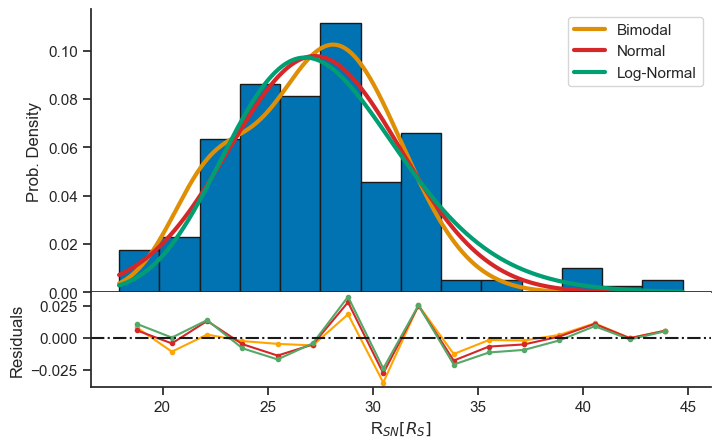

In [215]:
x_fit = np.linspace(min(data),max(data),1000) 

# plotting
fig = plt.figure(figsize =(8,5), dpi = 100)
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 1], hspace=0)
ax1, ax2 = gs.subplots(sharex=True)    
plt.setp(ax1.get_xticklabels(), visible=False)

counts, bins, bars = ax1.hist(data, bins= nbins, density=True ,edgecolor='k')
ax1.plot(x_fit, double_gaussian(x_fit,*popt), '-', label = "Bimodal", linewidth=3.0)
ax1.plot(x_fit, single_gaussian(x_fit,*popt1), '-', color ="tab:red", label = "Normal",linewidth=3.0)
ax1.plot(x_fit, log_gaussian(x_fit,*popt2), '-', label = "Log-Normal", linewidth=3.0)
#ax1.bar(x, y, width=.2, color='r', yerr=np.sqrt(y))
plt.xlabel(r"R$_{SN} [R_S]$")
ax1.set_ylabel("Prob. Density")
#plt.plot(x,y, ".")
ax1.legend(loc = "best")
ax2.plot(x, y - double_gaussian(x,*popt),".-", color = "orange")
ax2.plot(x, y - single_gaussian(x,*popt1),".-", color = "tab:red")
ax2.plot(x, y - log_gaussian(x,*popt2),".-", color = "g")
ax2.axhline(0, linestyle = "-.", color= "k")
ax2.set_ylabel("Residuals")
plt.savefig("histogram_RSN.pdf", dpi = 200)
plt.show()

(array([2., 1., 3., 2., 2., 2., 2., 0., 1., 1.]),
 array([-0.02379136, -0.01817549, -0.01255962, -0.00694374, -0.00132787,
         0.004288  ,  0.00990387,  0.01551975,  0.02113562,  0.02675149,
         0.03236736]),
 <BarContainer object of 10 artists>)

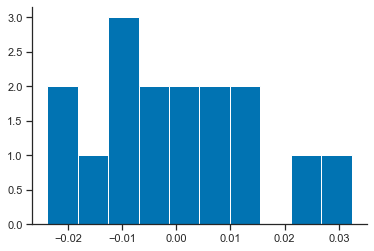

In [170]:
plt.hist(y - log_gaussian(x,*popt2))

## 2. P$_{SW}$ Histoplots

14.352700094407323


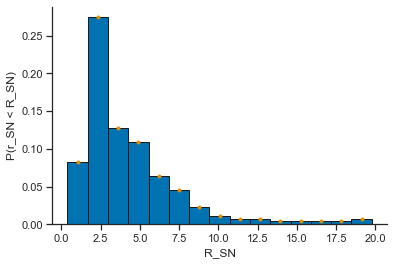

In [281]:
# histogram of solar wind dynamic pressure
data = P_Masters*100  # the +1 is is for the log fit 
print(np.sqrt(len(data)))
nbins = 15


plt.figure()
counts, bins, bars = plt.hist(data, bins= nbins ,density=True ,edgecolor='k')
plt.xlabel("R_SN")
plt.ylabel("P(r_SN < R_SN)")


offset = (bins[1] - bins[0])/2

x = bins[0:15] + offset 
y = counts

plt.plot(x, y, ".")

In [282]:
param_bounds=([0,0,0,0,0],[1,np.inf,np.inf,np.inf,np.inf])
mu, sigma = stats.norm.fit(data)
log_mu, log_sigma = stats.norm.fit(np.log(data))
print(log_mu, log_sigma)
p0 =  [0.5, mu, sigma, mu, sigma ] # initial guesses
popt, pcov = curve_fit(double_gaussian, x, y, p0=p0, bounds = param_bounds) # double fit

param_bounds=([0,0],[np.inf,np.inf])
p1 = [mu, sigma]
popt1, pcov1 = curve_fit(single_gaussian, x, y, p0=p1,bounds = param_bounds) # single fit
p2 = [0, log_sigma]
popt2, pcov2 = curve_fit(log_gaussian, x, y, p0=p2, bounds = param_bounds) # log fit

1.2115120558735837 0.6850408456697946


(1292024.382723939, 0.0)

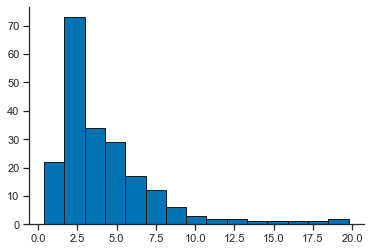

In [289]:
Obs, bins, bars = plt.hist(data, bins= nbins ,density=False ,edgecolor='k')
g = popt[0]
m1 = popt[1]
s1 = popt[2]
m2 = popt[3]
s2 = popt[4]
no = len(data)
E_bi = []
for i in range(len(bins)-1):
    low = bins[i]
    high = bins[i+1]
    N = quad(double_gaussian,low ,high, args=(g,m1, s1, m2,s2))
    E_bi.append(N[0] * no)
    
chi2_bi = np.sum((Obs - E_bi)/E_bi)
P_bi = quad(prob_chi2,chi2_bi ,np.inf, args=(9))
chi2_bi, P_bi[0]

In [184]:
# print uncertanties

print("double")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("single")
print(popt1)
print(np.sqrt(np.diag(pcov1)))
print("log")
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print("exp(log)")
print(np.exp(popt2))
logerror = np.sqrt(np.exp(popt2) * (np.sqrt(np.diag(pcov2))**2))
print(logerror) # need to fix this, not 100 % sure

double
[0.74993535 3.73238655 2.63471507 2.31452569 0.5703226 ]
[0.07734867 0.38962213 0.13424791 0.12040483 0.11995671]
single
[2.80529579 1.95905391]
[0.31196051 0.24958317]
log
[1.17050511 0.59348736]
[0.04317302 0.03070539]
exp(log)
[3.22362053 1.81029055]
[0.07751476 0.0413132 ]


In [185]:
chi2bi = 1 - np.sum((double_gaussian(x,*popt) - y) ** 2)/np.sum((y - np.average(double_gaussian(x,*popt)))**2)
chi2norm = 1 - np.sum((single_gaussian(x,*popt1) - y) ** 2)/np.sum((y - np.average(single_gaussian(x,*popt1)))**2)
chi2log = 1 - np.sum((log_gaussian(x,*popt2) - y) ** 2)/np.sum((y - np.average(log_gaussian(x,*popt2)))**2)
print(chi2bi, chi2norm, chi2log)

0.9949687086299945 0.8146311008562102 0.9433170898529828


In [188]:
chi2bi = np.sum((double_gaussian(x,*popt) - y) ** 2/double_gaussian(x,*popt))
chi2norm = np.sum((single_gaussian(x,*popt1) - y) ** 2/single_gaussian(x,*popt1))
chi2log = np.sum((log_gaussian(x,*popt2) - y) ** 2/log_gaussian(x,*popt2))
print(chi2bi, chi2norm, chi2log)

from scipy.special import gamma, factorial
from scipy.integrate import quad

def prob_chi2(chi2, ddof):
    num = chi2**(ddof/2-1)*np.exp(-chi2/2)
    den = 2**(ddof/2)*gamma(ddof/2)
    return num/den

P_bi = quad(prob_chi2,chi2bi ,np.inf, args=(9))
P_norm = quad(prob_chi2,chi2norm ,np.inf, args=(12))
P_log = quad(prob_chi2,chi2log ,np.inf, args=(12))
print(P_log)

12973.869095416636 321697966817.1977 0.19390523697838946
(0.9999999989383893, 7.84381460133332e-10)


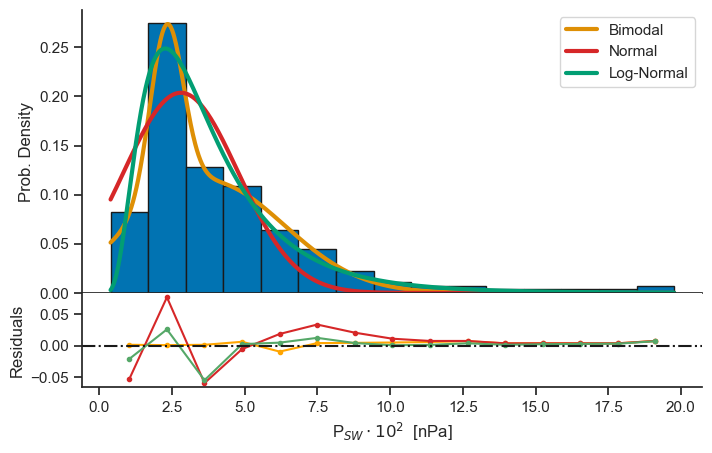

In [178]:
x_fit = np.linspace(min(data),max(data),1000) 

# plotting
fig = plt.figure(figsize =(8,5), dpi = 100)
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 1], hspace=0)
ax1, ax2 = gs.subplots(sharex=True)    
plt.setp(ax1.get_xticklabels(), visible=False)

counts, bins, bars = ax1.hist(data, bins= nbins, density=True ,edgecolor='k')
ax1.plot(x_fit, double_gaussian(x_fit,*popt), '-', label = "Bimodal", linewidth=3.0)
ax1.plot(x_fit, single_gaussian(x_fit,*popt1), '-', color ="tab:red", label = "Normal",linewidth=3.0)
ax1.plot(x_fit, log_gaussian(x_fit,*popt2), '-', label = "Log-Normal", linewidth=3.0)
plt.xlabel(r"P$_{SW}\cdot 10^2$  [nPa]")
ax1.set_ylabel("Prob. Density")
#plt.plot(x,y, ".")
ax1.legend(loc = "best")
ax2.plot(x, y - double_gaussian(x,*popt),".-", color = "orange")
ax2.plot(x, y - single_gaussian(x,*popt1),".-", color = "tab:red")
ax2.plot(x, y - log_gaussian(x,*popt2),".-", color = "g")
ax2.axhline(0, linestyle = "-.", color= "k")
ax2.set_ylabel("Residuals")
plt.savefig("histogram_PSW.pdf", dpi = 200)
plt.show()

# 2. Our Histograms

In [16]:
Cassini_time, X_SN,Y_SN,Z_SN = np.loadtxt("2004_FGM_KSM_1M.TAB", usecols = (0,5,6,7), unpack = True, dtype='str')   
Year, Month, Day, Hour_Minute = np.loadtxt("Manual_BScrossings_records.txt", usecols = (2,3,4,5), unpack = True, dtype='str', skiprows = 1)

In [17]:
X_manual = []
Y_manual = []
Z_manual = []
for i in range(len(Year)):
    dt_str = f'{Year[i]}-{Month[i]}-{Day[i]}T{Hour_Minute[i]}:30'
    loc = np.where(Cassini_time == dt_str)
    loc = loc[0][0]
    Xi = float(X_SN[loc])
    Yi = float(Y_SN [loc])
    Zi = float(Z_SN [loc])
    X_manual.append(Xi)
    Y_manual.append(Yi)
    Z_manual.append(Zi)
    
X_manual = np.array(X_manual)
Y_manual = np.array(Y_manual)
Z_manual = np.array(Z_manual)

In [18]:
#Computing the shock stand off position for masters data
r_manual = np.sqrt(X_manual**2+Y_manual**2+Z_manual**2)
costheta_manual = X_manual/r_manual
L_manual = r_manual*(1+1.05*costheta_manual)
R_manual = L_manual/2.05
P_manual = (12.3 / R_manual) ** 4.3

## 2.1 $R_{SN}$ Histoplots

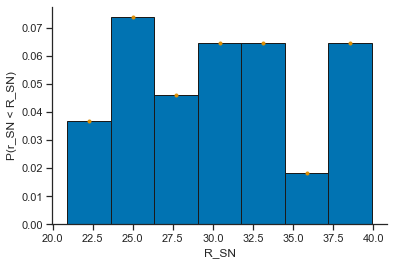

In [19]:
# histogram of solar wind dynamic pressure
data = R_manual # select R_SN data
nbins = 7 #number of bins for histogram

plt.figure()
counts, bins, bars = plt.hist(data, bins= nbins ,density=True ,edgecolor='k')
plt.xlabel("R_SN")
plt.ylabel("P(r_SN < R_SN)")


offset = (bins[1] - bins[0])/2 # the bins start at the left corner of the plot this offset you add 
                                # puts the dot in the middle

x = bins[0:nbins] + offset # rename for later
y = counts

plt.plot(x, y, ".") # plot!

In [20]:
param_bounds=([0,0,0,0,0],[1,np.inf,np.inf,np.inf,np.inf]) # bounds for parameters, not less than zero
mu, sigma = stats.norm.fit(data) # for initial guesses 
log_mu, log_sigma = stats.norm.fit(np.log(data)) # for log fit initial guess
p0 =  [0.5, mu, sigma, mu, sigma ] # initial guesses 
popt, pcov = curve_fit(double_gaussian, x, y, p0=p0, bounds = param_bounds) # double fit

param_bounds=([0,0],[np.inf,np.inf]) # bounds for parameters, not less than zero
p1 = [mu, sigma]# initial guesses 
popt1, pcov1 = curve_fit(single_gaussian, x, y, p0=p1,bounds = param_bounds) # single fit
p2 = [log_mu, log_sigma]# initial guesses 
popt2, pcov2 = curve_fit(log_gaussian, x, y, p0=p2, bounds = param_bounds) # log fit

In [21]:
# print uncertanties

print("double")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("single")
print(popt1)
print(np.sqrt(np.diag(pcov1)))
print("log")
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print("exp(log)")
print(np.exp(popt2))
logerror = np.sqrt(np.exp(popt2) * (np.sqrt(np.diag(pcov2))**2))
print(logerror) # need to fix this, not 100 % sure

double
[ 0.17082567 24.16487734  1.3174601  32.05596542  5.92470572]
[0.37299203 4.35764112 5.90988168 5.53362327 3.90362306]
single
[29.76154714  6.72592804]
[2.20391922 1.80188266]
log
[3.40637817 0.22381157]
[0.06898534 0.05759069]
exp(log)
[30.1558269   1.25083531]
[0.37882833 0.06440986]


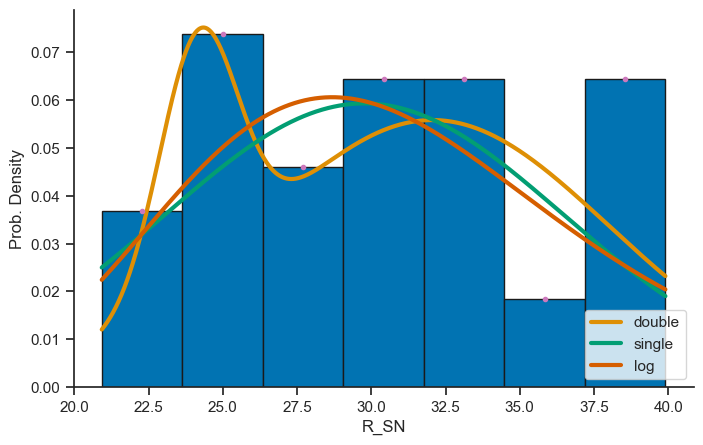

In [22]:
x_fit = np.linspace(min(data),max(data),1000) 

# plotting
plt.figure(figsize =(8,5), dpi = 100)
counts, bins, bars = plt.hist(data, bins= nbins, density=True ,edgecolor='k')
plt.plot(x_fit, double_gaussian(x_fit,*popt), '-', label = "double", linewidth=3.0)
plt.plot(x_fit, single_gaussian(x_fit,*popt1), '-', label = "single",linewidth=3.0)
plt.plot(x_fit, log_gaussian(x_fit,*popt2), '-', label = "log", linewidth=3.0)
plt.xlabel("R_SN")
plt.ylabel("Prob. Density")
plt.plot(x,y, ".")
plt.legend(loc = "best")
plt.show()

## 2.2 $P_{SW}$ Histogram

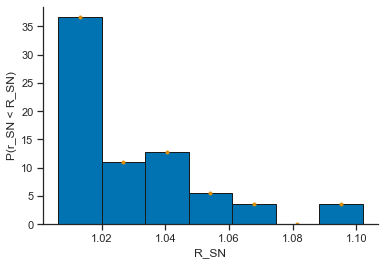

In [23]:
# histogram of solar wind dynamic pressure
data = P_manual +1  # select R_SN data
nbins = 7 #number of bins for histogram

plt.figure()
counts, bins, bars = plt.hist(data, bins= nbins ,density=True ,edgecolor='k')
plt.xlabel("R_SN")
plt.ylabel("P(r_SN < R_SN)")


offset = (bins[1] - bins[0])/2 # the bins start at the left corner of the plot this offset you add 
                                # puts the dot in the middle

x = bins[0:nbins] + offset # rename for later
y = counts

plt.plot(x, y, ".") # plot!

In [24]:
param_bounds=([0,0,0,0,0],[1,np.inf,np.inf,np.inf,np.inf]) # bounds for parameters, not less than zero
mu, sigma = stats.norm.fit(data) # for initial guesses 
log_mu, log_sigma = stats.norm.fit(np.log(data)) # for log fit initial guess
p0 =  [0.5, mu, sigma, mu, sigma ] # initial guesses 
popt, pcov = curve_fit(double_gaussian, x, y, p0=p0, bounds = param_bounds) # double fit

param_bounds=([0,0],[np.inf,np.inf]) # bounds for parameters, not less than zero
p1 = [mu, sigma]# initial guesses 
popt1, pcov1 = curve_fit(single_gaussian, x, y, p0=p1,bounds = param_bounds) # single fit
p2 = [log_mu, log_sigma]# initial guesses 
popt2, pcov2 = curve_fit(log_gaussian, x, y, p0=p2, bounds = param_bounds) # log fit

In [25]:
# print uncertanties

print("double")
print(popt)
print(np.sqrt(np.diag(pcov)))
print("single")
print(popt1)
print(np.sqrt(np.diag(pcov1)))
print("log")
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print("exp(log)")
print(np.exp(popt2))
logerror = np.sqrt(np.exp(popt2) * (np.sqrt(np.diag(pcov2))**2))
print(logerror) # need to fix this, not 100 % sure

double
[0.44441776 1.00977591 0.00287023 1.03490877 0.01765918]
[1.00467193e+00 4.62745241e+02 1.38109262e+03 3.73003265e-02
 2.13095703e-02]
single
[1.01116122 0.01116003]
[0.00354399 0.00191456]
log
[0.01118251 0.01106473]
[0.00351765 0.00189781]
exp(log)
[1.01124527 1.01112618]
[0.00353737 0.00190834]


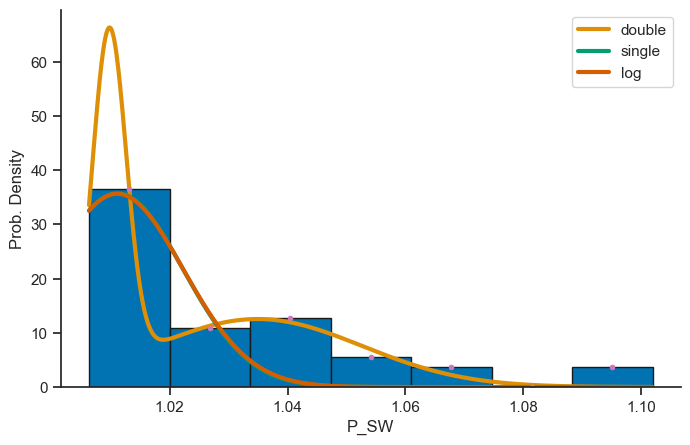

In [26]:
x_fit = np.linspace(min(data),max(data),1000) 

# plotting
plt.figure(figsize =(8,5), dpi = 100)
counts, bins, bars = plt.hist(data, bins= nbins, density=True ,edgecolor='k')
plt.plot(x_fit, double_gaussian(x_fit,*popt), '-', label = "double", linewidth=3.0)
plt.plot(x_fit, single_gaussian(x_fit,*popt1), '-', label = "single",linewidth=3.0)
plt.plot(x_fit, log_gaussian(x_fit,*popt2), '-', label = "log", linewidth=3.0)
plt.xlabel("P_SW")
plt.ylabel("Prob. Density")
plt.plot(x,y, ".")
plt.legend(loc = "best")
plt.show()